# Statistical Outlier Detection

This anomaly detection method involves computing basic statistics about the data and determining outliers based on z-score values. 

How to calculate a z-score for a given technical indicator x:\
z-score = (mean - x)/standard_deviation

We consider an outlier to be any date at which one of the technical indicators was outside of a 4 standard deviation range from its mean. We also consider the Mahalanobis distance, which accounts for covariance between two indicators.

In [119]:
# import necessary dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis
import numpy as np
import seaborn as sns

In [120]:
data = pd.read_csv('intc_data.csv')

In [121]:
# convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.to_period('M').astype(str)


C:\Users\Tejas Srivatsav\AppData\Local\Temp\ipykernel_49032\1242915174.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.to_period('M').astype(str)


In [122]:
print(data['Date'])

0       1985-01
1       1985-01
2       1985-01
3       1985-01
4       1985-01
         ...   
7559    2014-12
7560    2014-12
7561    2014-12
7562    2014-12
7563    2014-12
Name: Date, Length: 7564, dtype: object


In [123]:
# Indicators to consider
indicators = ['Volume', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']

# Calculate Z-scores for the specified indicators
z_scores = zscore(data[indicators])

# Set a threshold for identifying outliers
threshold = 4

# Identify outliers based on the threshold
outliers = data[(z_scores > threshold) | (z_scores < -threshold)]

In [124]:
print(outliers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7564 entries, 0 to 7563
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          0 non-null      object 
 1   Open          0 non-null      float64
 2   High          0 non-null      float64
 3   Low           0 non-null      float64
 4   Close         0 non-null      float64
 5   Volume        48 non-null     float64
 6   Dividends     0 non-null      float64
 7   Stock Splits  0 non-null      float64
 8   Return        0 non-null      float64
 9   SMA_50        0 non-null      float64
 10  EMA_20        0 non-null      float64
 11  WMA_30        0 non-null      float64
 12  RSI           0 non-null      float64
 13  Upper_BB      0 non-null      float64
 14  Lower_BB      0 non-null      float64
 15  MACD          40 non-null     float64
 16  Signal_Line   0 non-null      float64
dtypes: float64(16), object(1)
memory usage: 1004.7+ KB
None


As we can see, there are 48 outliers in volume and 40 outliers in MACD. Let's visualize them.

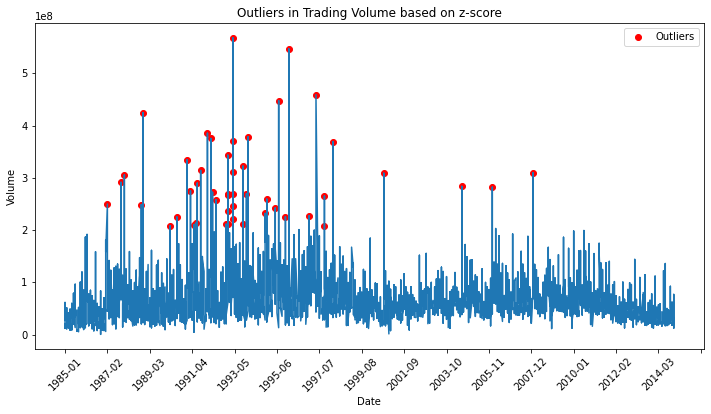

In [125]:
# Fetch the correct dates
volume_outliers_not_na = outliers[outliers['Volume'].notna()]
outlier_indices = volume_outliers_not_na.index.tolist()
volume_outlier_dates = data['Date'].loc[outlier_indices].tolist()
# Plot volume
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volume'])
plt.scatter(volume_outlier_dates, volume_outliers_not_na['Volume'], color='red', label='Outliers')
plt.title('Outliers in Trading Volume based on z-score')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(25))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

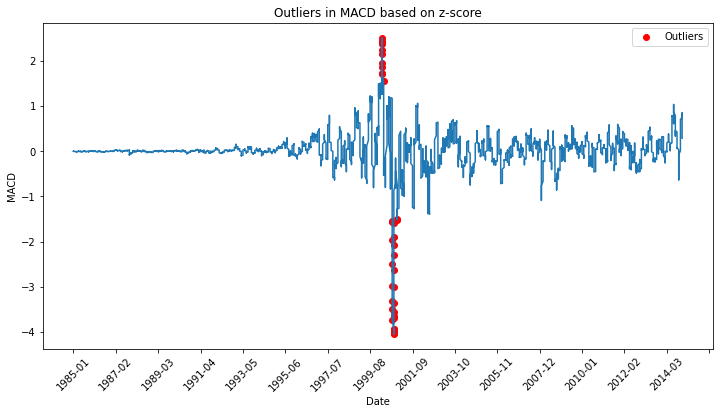

In [126]:
# Fetch the correct dates
macd_outliers_not_na = outliers[outliers['MACD'].notna()]
outlier_indices = macd_outliers_not_na.index.tolist()
macd_outlier_dates = data['Date'].loc[outlier_indices].tolist()
# Plot MACD
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['MACD'])
plt.scatter(macd_outlier_dates, macd_outliers_not_na['MACD'], color='red', label='Outliers')
plt.title('Outliers in MACD based on z-score')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(25))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.show()

Next, we consider the Mahalanobis distance -- A metric that finds the distance between each multivariate data point and the mean of the data.

In [127]:
# Calculate Mahalanobis distance
cov_matrix = data[indicators].cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)
mahalanobis_distances = []
for _, row in data.iterrows():
    mahalanobis_dist = mahalanobis(row[indicators], data[indicators].mean(), inv_cov_matrix)
    mahalanobis_distances.append(mahalanobis_dist)
mahalanobis_distances = pd.Series(mahalanobis_distances)


Let's visualize a density plot of the distances so that we can choose an appropriate threshold

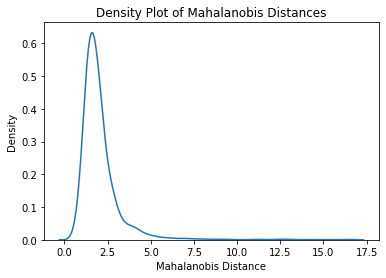

In [128]:
sns.kdeplot(mahalanobis_distances)
plt.title('Density Plot of Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Density')
plt.show()

Based on the plot above, we set the threshold to 10

In [129]:
# Set Mahalanobis distance threshold
mahalanobis_distance_threshold = 10

# Identify outliers 
outliers_mahalanobis = data[mahalanobis_distances > mahalanobis_distance_threshold]

In [130]:
print(outliers_mahalanobis.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 983 to 4006
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          43 non-null     object 
 1   Open          43 non-null     float64
 2   High          43 non-null     float64
 3   Low           43 non-null     float64
 4   Close         43 non-null     float64
 5   Volume        43 non-null     int64  
 6   Dividends     43 non-null     float64
 7   Stock Splits  43 non-null     float64
 8   Return        43 non-null     float64
 9   SMA_50        43 non-null     float64
 10  EMA_20        43 non-null     float64
 11  WMA_30        43 non-null     float64
 12  RSI           43 non-null     float64
 13  Upper_BB      43 non-null     float64
 14  Lower_BB      43 non-null     float64
 15  MACD          43 non-null     float64
 16  Signal_Line   43 non-null     float64
dtypes: float64(15), int64(1), object(1)
memory usage: 6.0+ KB
None


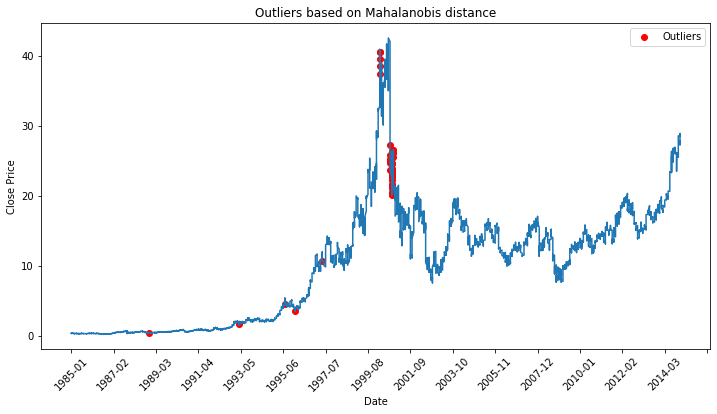

In [133]:
# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'])
plt.scatter(outliers_mahalanobis['Date'], outliers_mahalanobis['Close'], color='red', label='Outliers')
plt.title('Outliers based on Mahalanobis distance')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(25))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

As we can see, many of the outliers seem to be associated with the Dot-Com Crash of 2000.